In [1]:
%load_ext autoreload
%autoreload 2

import os

import hydra
import matplotlib.pyplot as plt
import torch
import numpy as np
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
from openretina.insilico.vector_field_analysis.vector_field_analysis import (
    compute_lsta_library,
    get_images_coordinate,
    get_pc_from_pca,
    plot_clean_vectorfield,
    prepare_movies_dataset,
)
from openretina.models.core_readout import load_core_readout_from_remote, load_core_readout_model
from openretina.utils.file_utils import get_local_file_path

In this notebook, we will introduce how to use OpenRetina to compute the vector field of local Spike Triggered Average (LSTA) as described in Goldin et al. 2022. This analysis can be used as a complement to the Most Discriminative Stimulus analysis. The method should work for most models trained in the OpenRetina framework but the user might need to readapt how the dataset of natural images is constructed (usually from snippets of the training dataset).

# Load model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_quality = "low"
model_name = f"https://huggingface.co/datasets/open-retina/open-retina/blob/main/model_checkpoints/24-01-2025/hoefling_2024_base_low_res.ckpt"
device="cuda" if torch.cuda.is_available() else "cpu"
model = load_core_readout_model(model_name, device = device)
model

/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/lightning/pytorch/core/saving.py:165: You are using ExampleCoreReadout, which is intended as a reference/example class for custom core-readout model implementations. For most configuration-driven workflows, especially if you use Hydra, consider using UnifiedCoreReadout instead, or writing your own class that inherits from BaseCoreReadout.
/home/idv-s8/Documents/LabPipeline/open-retina/openretina/modules/readout/base.py:63: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'core' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['core'])`.
/home/idv-s8/Documents/LabPipeline/open-re

ExampleCoreReadout(
  (core): <super: <class 'Core'>, <SimpleCoreWrapper object>> [SimpleCoreWrapper regularizers: gamma_hidden = 0.0|gamma_in_sparse = 0.0|gamma_input = 0.0|gamma_temporal = 40.0]
  
  (readout): MultiGaussianMaskReadout(
    (session_1_ventral1_20200226): GaussianMaskReadout ( 16 x 8 x 6 -> 80)
    
    (session_1_ventral1_20200528): GaussianMaskReadout ( 16 x 8 x 6 -> 42)
    
    (session_1_ventral1_20200707): GaussianMaskReadout ( 16 x 8 x 6 -> 74)
    
    (session_1_ventral1_20201021): GaussianMaskReadout ( 16 x 8 x 6 -> 32)
    
    (session_1_ventral1_20201030): GaussianMaskReadout ( 16 x 8 x 6 -> 40)
    
    (session_1_ventral1_20210929): GaussianMaskReadout ( 16 x 8 x 6 -> 48)
    
    (session_1_ventral1_20210930): GaussianMaskReadout ( 16 x 8 x 6 -> 26)
    
    (session_1_ventral2_20200302): GaussianMaskReadout ( 16 x 8 x 6 -> 41)
    
    (session_1_ventral2_20200707): GaussianMaskReadout ( 16 x 8 x 6 -> 56)
    
    (session_1_ventral2_20201021): Gaussi

In [3]:
# pick a session if needed
session_id = "session_2_ventral2_20210929"  # list(model.readout.keys())[0]
print("Using session : ", session_id)
n_neurons = model.readout[session_id].outdims
print(f"Number of neurons: {n_neurons}")

Using session :  session_2_ventral2_20210929
Number of neurons: 48


In [4]:
sessions = list(model.readout.keys())

# Optional / We will reshape the cell type annotations into a new format to use it later down
group_sessions_cells = {}

# Iterate through all sessions
for session in sessions:
    # Get assignments for this session
    assignments = model.data_info["sessions_kwargs"][session]["group_assignment"]

    # Get number of neurons for this session
    n_neurons = model.readout[session].outdims

    # For each cell in this session
    for cell_id in range(n_neurons):
        group = int(assignments[cell_id])  # Convert to int for dictionary key

        # Initialize group if not exists
        if group not in group_sessions_cells:
            group_sessions_cells[group] = {}

        # Initialize session if not exists for this group
        if session not in group_sessions_cells[group]:
            group_sessions_cells[group][session] = []

        # Add cell ID to the appropriate group and session
        group_sessions_cells[group][session].append(cell_id)

# Load natural images

We need to create a dataset of natural images to which we will compute the lSTA to. For movie models we can simply take random frames from the movies. We recommend using ~3000 images.

In [5]:
# In the case of Hoefling et al, let's load training data
with hydra.initialize(config_path=os.path.join("..", "configs"), version_base="1.3"):
    cfg = hydra.compose(config_name=f"hoefling_2024_core_readout_{model_quality}_res.yaml")

movies_path = get_local_file_path(file_path=cfg.paths.movies_path, cache_folder=cfg.paths.data_dir)

movies_dict = movies_from_pickle(movies_path)

In [6]:
model.data_info['movie_norm_dict']

{'default': {'norm_mean': None, 'norm_std': None}}

In [7]:
# We will just take equally intervleaved frames from the training movies to create a dataset of natural images.
# We will just take equally intervleaved frames from the training movies to create a dataset of natural images.
n_images = 3000
rate = movies_dict.train.shape[1] // n_images
natural_images_library = movies_dict.train[:, ::rate, :, :].swapaxes(0, 1)
natural_images_library = natural_images_library[:n_images]
print(f"natural_images_library.shape: {natural_images_library.shape}, n_images: {n_images}")

natural_images_library.shape: (3000, 2, 18, 16), n_images: 3000


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


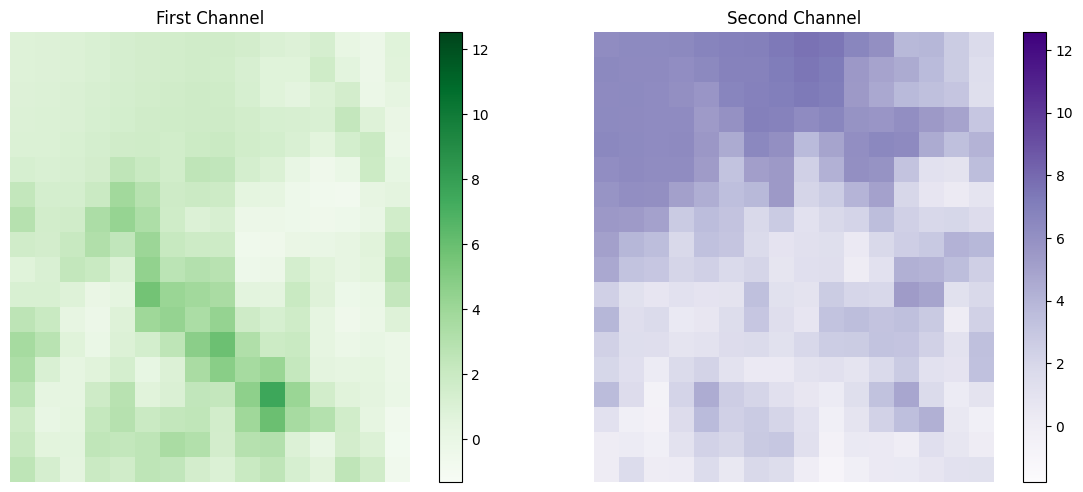

First channel range: [-0.781, 7.500]
Second channel range: [-0.971, 7.581]


In [8]:
# The next function will turn our images into singular sequence grey -> frame,
# using a length of grey depending on the size of the model temporal filtering
# The n_image_frames is the number of frames the natural image is displayed, depending on the window you want to average
# the cell response for LSTA computation (see below).
movies, n_empty_frames = prepare_movies_dataset(
    model,
    session_id,
    normalize_movies=False,  # Already normalized
    image_library=natural_images_library,
    n_image_frames=60,
    device=device,
)

# Double the variance for each channel in movies
for c in range(movies.shape[1]):
    channel_mean = movies[:, c].mean() 
    movies[:, c] = (movies[:, c] - channel_mean) * 2 + channel_mean

# Make second channel constant
# movies[:, 1] = movies[:, 1].min()

# Display the last frame of an example movie with both channels side by side
example_idx = 150  # First movie as example
last_frame = movies[example_idx, :, -1]  # movies[example_idx, :, -1]  # Shape: (2, 72, 64)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First channel (channel 0)
im1 = axes[0].imshow(last_frame[0], cmap="Greens", vmin=movies[:, 0].min(), vmax=movies[:, 0].max())
axes[0].set_title("First Channel")
plt.colorbar(im1, ax=axes[0])
axes[0].axis("off")
# Optional : Second channel (channel 1)
im2 = axes[1].imshow(last_frame[1], cmap="Purples", vmin=movies[:, 1].min(), vmax=movies[:, 1].max())
axes[1].set_title("Second Channel")
plt.colorbar(im2, ax=axes[1])
axes[1].axis("off")
plt.tight_layout()
plt.show()

print(f"First channel range: [{last_frame[0].min():.3f}, {last_frame[0].max():.3f}]")
print(f"Second channel range: [{last_frame[1].min():.3f}, {last_frame[1].max():.3f}]")

# Draw the vector field for a selected cell

In [9]:
cell_id = 18 # Good example = 11  # TO DO: CHOOSE BETTER EXAMPLE

# The following function will compute the response and the lSTA to all the images in the movies dataset
# Choose an integration window that makes sense for your model (here 5-40 frames after image onset, i.e. 0.17s to 1.33s
#  after image onset)
movies = movies
lsta_library, response_library = compute_lsta_library(
    model,
    movies,  # Can limit number of images for it to run faster
    session_id,
    cell_id,
    integration_window=(10,30),  # Integration window for the LSTA
    batch_size=64,
    device=device,
)

In [10]:
lsta_library.shape, response_library.shape

((3000, 2, 18, 16), (3000, 70, 48))

Text(0, 0.5, 'Cell predicted Response (au)')

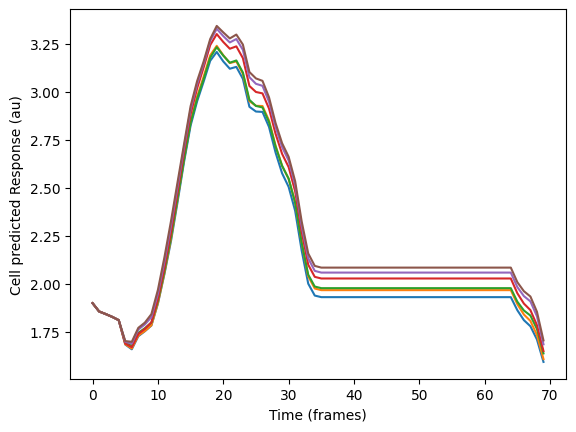

In [11]:
# We can check some sample responses, making sure the integrity of the response profile is predicted and we did not
#  cut it too short.
# This view can be used to help select the integration window (typical number of frames on the cell response
#  in the dataset)

plt.plot(response_library[0, :, cell_id])
plt.plot(response_library[1, :, cell_id])
plt.plot(response_library[2, :, cell_id])
plt.plot(response_library[3, :, cell_id])
plt.plot(response_library[4, :, cell_id])
plt.plot(response_library[5, :, cell_id])
plt.xlabel("Time (frames)")
plt.ylabel("Cell predicted Response (au)")

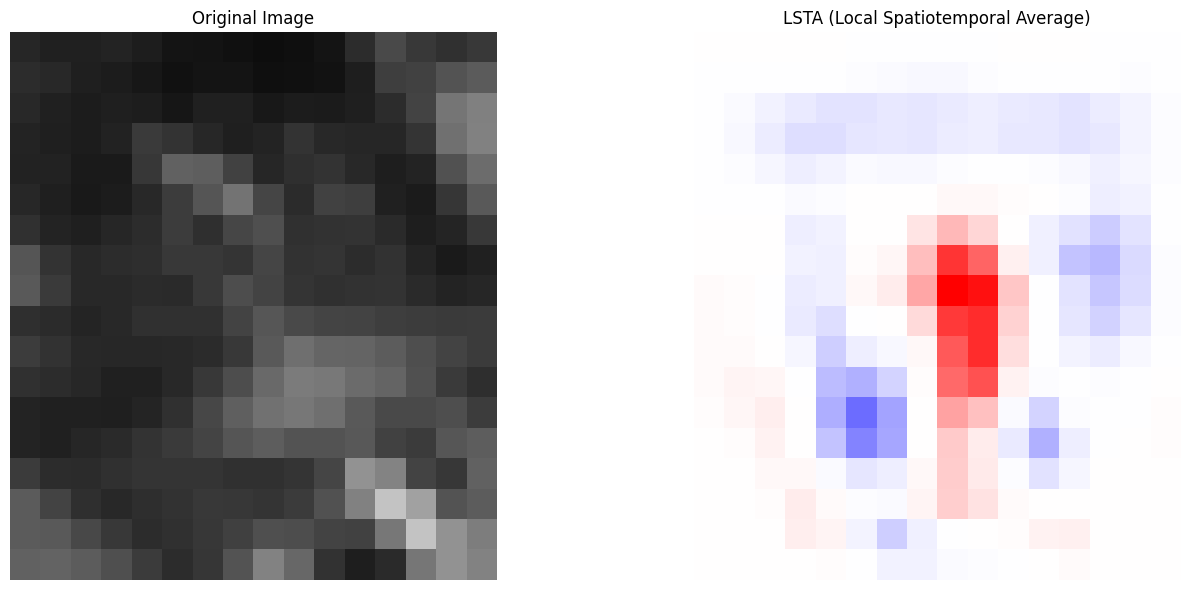

In [12]:
# We can now plot an example LSTA and the corresponding image

image = 1400
channel = 0
lsta = lsta_library[image, channel]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# image
vmax_img = movies.max()
vmin_img = movies.min()
axes[0].imshow(movies[image, 0, -1], cmap="gray", vmin=vmin_img, vmax=vmax_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

# LSTA
lsta = np.sign(lsta) * np.exp(np.log(abs(lsta)) * 2)
axes[1].imshow(lsta, cmap="bwr", vmin=-abs(lsta).max(), vmax=abs(lsta).max())
axes[1].set_title("LSTA (Local Spatiotemporal Average)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Image to show 1400 (ON) and 2650 (OFF) 
ex_image_ON = movies[1400, 0, -1]
ex_LSTA_ON = lsta_library[1400, 0]
ex_image_OFF = movies[2650, 0, -1]
ex_LSTA_OFF = lsta_library[2650, 0]

In [14]:
ex_image_ON.max(), ex_image_OFF.max(), ex_image_ON.min(), ex_image_OFF.min()

(np.float64(9.219045117054701),
 np.float64(7.1702733167229304),
 np.float64(-1.0462955017169329),
 np.float64(-0.932954968037569))

# PCA on the LSTA library

Interpretation : Here we are drawing a approximation of what are the spatial components of the cell lSTA. They are the two axis directing the cell selectivity, usually the first PC looks like a simple receptive field and can be seen as a 'luminance' axis, while the second PC is more complex spatially and can be seen as a 'local contrast' axis.

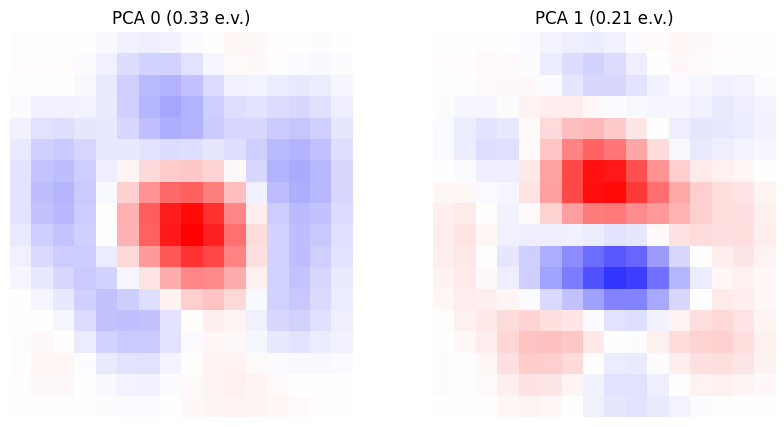

In [15]:
# Select channel if using a color channels model
channel = 0

PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)

(np.float64(-27.129951361590916),
 np.float64(19.40601382538696),
 np.float64(-14.990830116410748),
 np.float64(29.894377385546868))

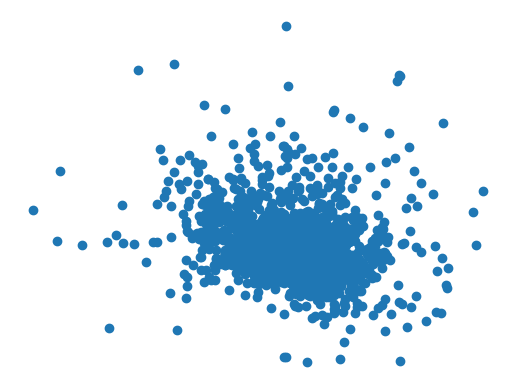

In [16]:
# Project the images onto PCA space
images = movies[:, channel, -1, :, :]
images_coordinate = get_images_coordinate(images, PC1, PC2, plot=True)
plt.axis("off")
plt.axis("off")

In [17]:
images.min(), images.max()

(np.float64(-1.313542288869515), np.float64(12.52292560484269))

In [18]:
images.shape

(3000, 18, 16)

# Plot the vector field

Interpretation :
We can project both the images (represented as arrow basis) and the corresponding lSTAs (represented as arrow heads) on the two first PCs. This give use a view of the geometry of the response space of the cell. If the arrow all points in the same horizontal direction, the cell consistently encode the same thing. If the directions arrows vary, the cell selectivity depends on the current context. Arrows diverging can be interpreted as a preference for increase in local contrast in a part of stimulus space, while arrows converging could be a preference for decrease in local contrast.

In [19]:
# OPTIONAL : Plot the raw vector field of the LSTA in PCA space
# fig = plot_untreated_vectorfield(lsta_library, channel, PC1, PC2, images_coordinate)

In [20]:
lsta_library.shape, images_coordinate.shape

((3000, 2, 18, 16), (3000, 2))

In [21]:
import numpy as np

# Load the npz file
data_MEI_ON = np.load("mei_and_init_kernels_ON.npz")
data_MEI_OFF = np.load("mei_and_init_kernels_OFF.npz")

# List the files inside the archive
print(data_MEI_ON.files)
print(data_MEI_OFF.files)

['mei_temporal_green', 'mei_temporal_uv', 'mei_spatial_green', 'mei_spatial_uv', 'init_temporal_green', 'init_temporal_uv', 'init_spatial_green', 'init_spatial_uv']
['mei_temporal_green', 'mei_temporal_uv', 'mei_spatial_green', 'mei_spatial_uv', 'init_temporal_green', 'init_temporal_uv', 'init_spatial_green', 'init_spatial_uv']


In [22]:
data_MEI_OFF['init_spatial_green'].min(), data_MEI_OFF['init_spatial_green'].max()

(np.float32(-0.9195643), np.float32(1.0))

In [23]:
data_MEI_ON['mei_spatial_green'].min(), data_MEI_ON['mei_spatial_green'].max()
data_MEI_OFF['mei_spatial_green'].min(), data_MEI_OFF['mei_spatial_green'].max()
STIMULUS_RANGE_CONSTRAINTS = {
    "norm": 5.0,
    "x_min_green": -0.654,
    "x_max_green": 6.269,
    "x_min_uv": -0.913,
    "x_max_uv": 6.269,
}
mei_spatial_green_ON = (data_MEI_ON['mei_spatial_green']) * STIMULUS_RANGE_CONSTRAINTS['norm'] #/2 * (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] - STIMULUS_RANGE_CONSTRAINTS['x_min_green']) + (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] + STIMULUS_RANGE_CONSTRAINTS['x_min_green']) / 2
mei_spatial_green_OFF = (data_MEI_OFF['mei_spatial_green']) * STIMULUS_RANGE_CONSTRAINTS['norm'] #/2 * (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] - STIMULUS_RANGE_CONSTRAINTS['x_min_green']) + (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] + STIMULUS_RANGE_CONSTRAINTS['x_min_green']) / 2
init_spatial_green_ON = (data_MEI_ON['init_spatial_green']) * STIMULUS_RANGE_CONSTRAINTS['norm'] # /2 * (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] - STIMULUS_RANGE_CONSTRAINTS['x_min_green']) + (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] + STIMULUS_RANGE_CONSTRAINTS['x_min_green']) / 2
init_spatial_green_OFF = (data_MEI_OFF['init_spatial_green']) * STIMULUS_RANGE_CONSTRAINTS['norm'] #/2 * (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] - STIMULUS_RANGE_CONSTRAINTS['x_min_green']) + (STIMULUS_RANGE_CONSTRAINTS['x_max_green'] + STIMULUS_RANGE_CONSTRAINTS['x_min_green']) / 2 

(np.float64(-0.5), np.float64(15.5), np.float64(17.5), np.float64(-0.5))

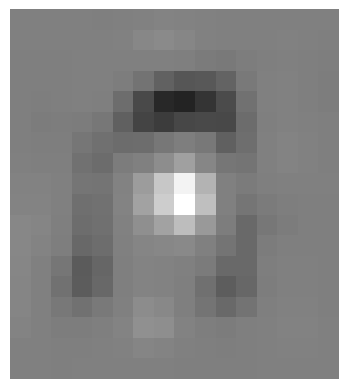

In [24]:
expon_treat = 2
mei_spatial_green_ON_for_plot = mei_spatial_green_ON.copy()
mei_spatial_green_ON_for_plot = np.exp(np.log(abs(mei_spatial_green_ON_for_plot)) * expon_treat) * np.sign(mei_spatial_green_ON_for_plot)
vmax = abs(mei_spatial_green_ON_for_plot).max()
plt.imshow(mei_spatial_green_ON_for_plot, cmap='grey', vmin=-vmax, vmax=vmax)
plt.axis("off")

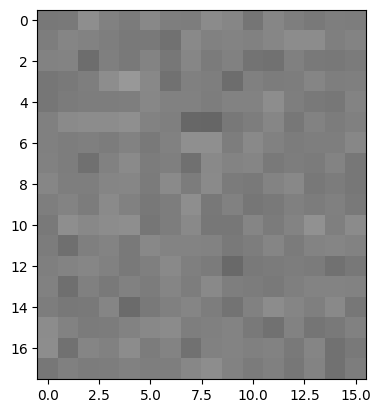

In [25]:
plt.imshow(init_spatial_green_ON, cmap='gray', vmin=-vmax, vmax=vmax)

(np.float64(-0.5), np.float64(15.5), np.float64(17.5), np.float64(-0.5))

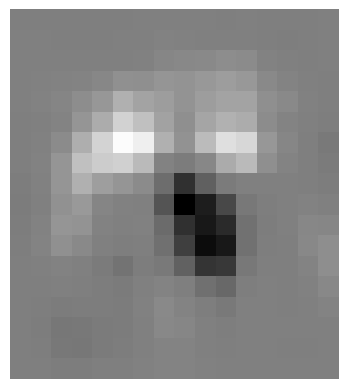

In [26]:
expon_treat = 2
mei_spatial_green_OFF_for_plot = mei_spatial_green_OFF.copy()
mei_spatial_green_OFF_for_plot = np.exp(np.log(abs(mei_spatial_green_OFF_for_plot)) * expon_treat) * np.sign(mei_spatial_green_OFF_for_plot)
vmax = abs(mei_spatial_green_OFF_for_plot).max()
plt.imshow(mei_spatial_green_OFF_for_plot, cmap='grey', vmin=-vmax, vmax=vmax)
plt.axis("off")

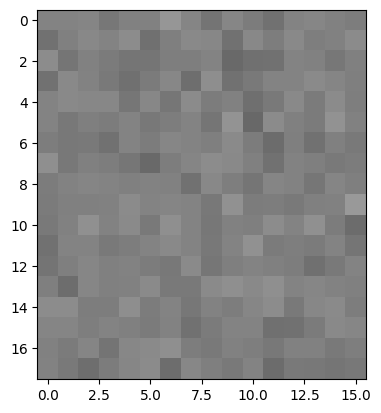

In [27]:
plt.imshow(init_spatial_green_OFF, cmap='gray', vmin=-vmax, vmax=vmax)

In [28]:
mei_ON_coord = get_images_coordinate(mei_spatial_green_ON.reshape(1,18,16), PC1, PC2, plot=False)
mei_OFF_coord = get_images_coordinate(mei_spatial_green_OFF.reshape(1,18,16), PC1, PC2, plot=False)
init_ON_coord = get_images_coordinate(init_spatial_green_ON.reshape(1,18,16), PC1, PC2, plot=False)
init_OFF_coord = get_images_coordinate(init_spatial_green_OFF.reshape(1,18,16), PC1, PC2, plot=False)
ex_img_ON_coord = get_images_coordinate(ex_image_ON.reshape(1,18,16), PC1, PC2, plot=False)
ex_img_OFF_coord = get_images_coordinate(ex_image_OFF.reshape(1,18,16), PC1, PC2, plot=False)

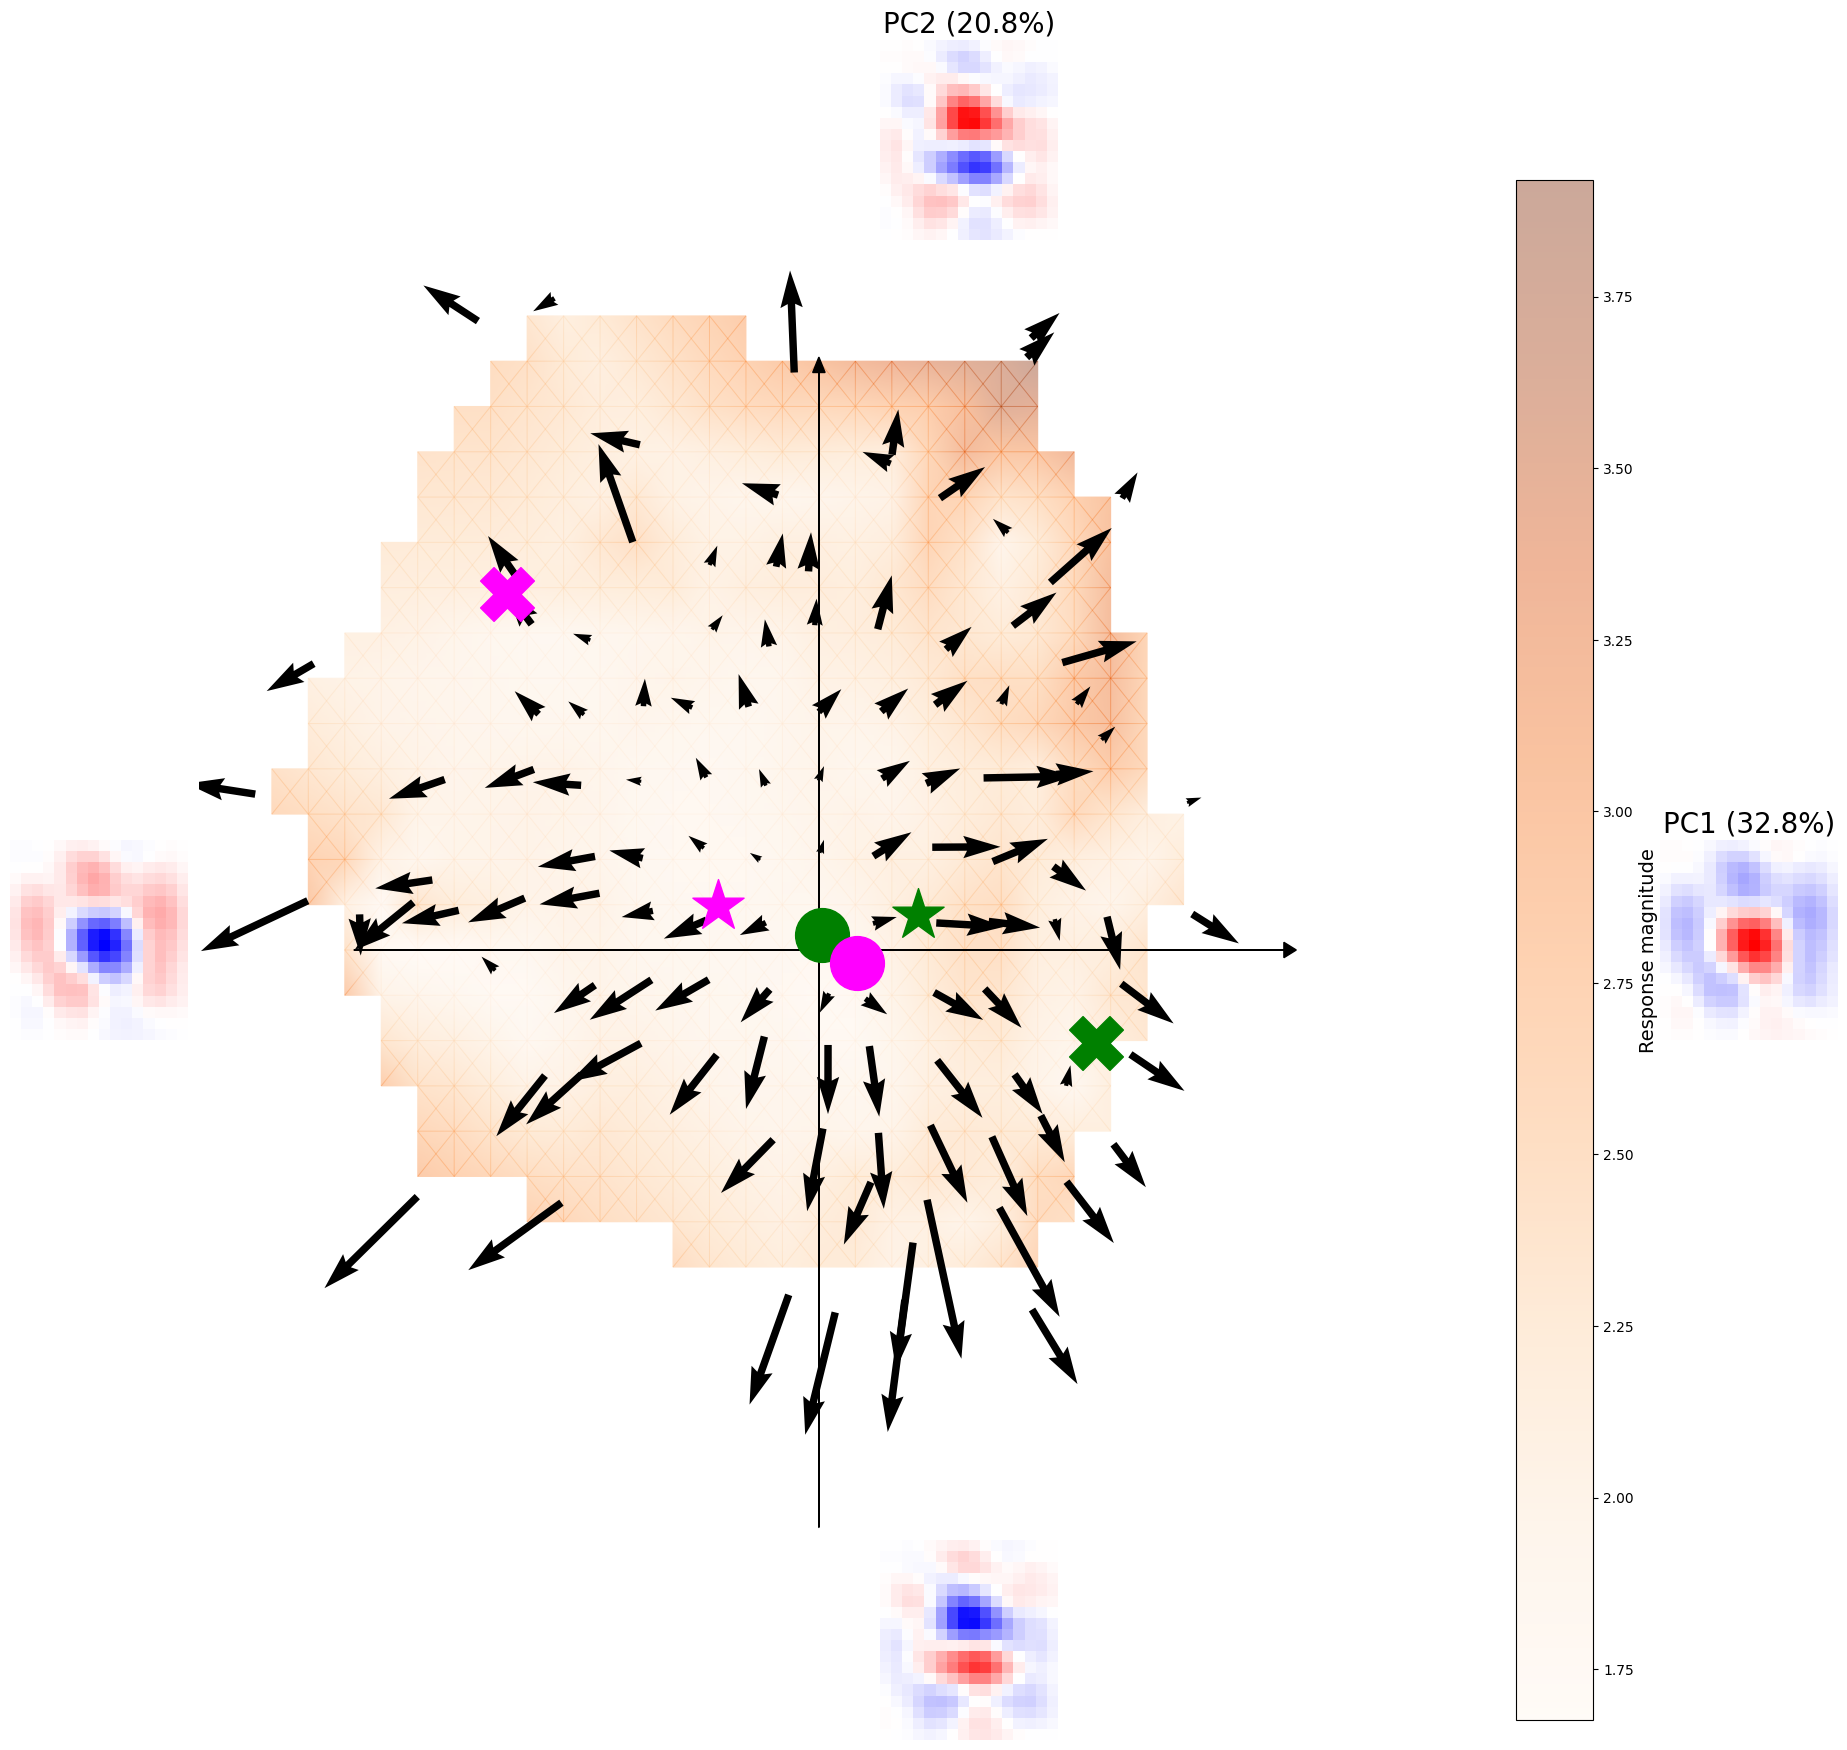

In [29]:
# Plot the optimiz vector field of the LSTA in PCA space
fig = plot_clean_vectorfield(
    lsta_library,
    channel,
    PC1,
    PC2,
    images,
    images_coordinate,
    explained_variance,
    responses=response_library,
    x_bins=16,
    y_bins=16,
    scale_factor=0.5,
)
fig.axes[0].scatter(mei_ON_coord[0,0], mei_ON_coord[0,1], color='green', s=1500, marker='X', label='MEI ON', zorder=10)
fig.axes[0].scatter(mei_OFF_coord[0,0], mei_OFF_coord[0,1], color='magenta', s=1500, marker='X', label='MEI OFF', zorder=10)
fig.axes[0].scatter(init_ON_coord[0,0], init_ON_coord[0,1], color='green', s=1500, marker='o', label='Init ON', zorder=10)
fig.axes[0].scatter(init_OFF_coord[0,0], init_OFF_coord[0,1], color='magenta', s=1500, marker='o', label='Init OFF', zorder=10)
fig.axes[0].scatter(ex_img_ON_coord[0,0], ex_img_ON_coord[0,1], color='green', s=1500, marker='*', label='Ex Image ON', zorder=10)
fig.axes[0].scatter(ex_img_OFF_coord[0,0], ex_img_OFF_coord[0,1], color='magenta', s=1500, marker='*', label='Ex Image OFF', zorder=10)
# fig.axes[0].legend()
plt.show()


# ADD the firing rate by the side + mention cell types

# Optional : Create all arrowplots of a session

In [30]:
STOP

NameError: name 'STOP' is not defined

80


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


42
74
32
40
Processing cell 22...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


48


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


26
41
56
39
Processing cell 25...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


42


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


84
46
44
Processing cell 37...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


33


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


59
Processing cell 6...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


Processing cell 35...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


56


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


35
72
50
42
29
Processing cell 0...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


55


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 1...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


49


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 24...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


55


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 53...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


44


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


44
59
Processing cell 4...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/home/idv-s8/Documents/LabPipeline/open-retina/openretina/insilico/vector_field_analysis/vector_field_analysis.py:683: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(20, 20))
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


47


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 37...


/home/idv-s8/Documents/LabPipeline/open-retina/openretina/insilico/vector_field_analysis/vector_field_analysis.py:366: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


48


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


91
55
Processing cell 34...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


52


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 9...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


38


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 16...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


48


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 18...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


45


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 29...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


31


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


75
Processing cell 23...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


50


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


43
Processing cell 29...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


37


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


48
Processing cell 0...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


Processing cell 37...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


Processing cell 45...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


43


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


47
77
Processing cell 8...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


51


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


44
Processing cell 4...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


Processing cell 24...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


36


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


Processing cell 4...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


50


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


31
38
36
41
Processing cell 36...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


5


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


39
Processing cell 32...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


60


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


54
30
Processing cell 5...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


34


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


41
32
71
59
Processing cell 14...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


30


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


26
Processing cell 7...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


44


/home/idv-s8/Documents/LabPipeline/open-retina/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: UserWarning: No data key provided, returning concatenated responses from all readouts
  return forward_call(*args, **kwargs)


41
Processing cell 20...


/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()
/tmp/ipykernel_26305/956237950.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.axes[0].legend()


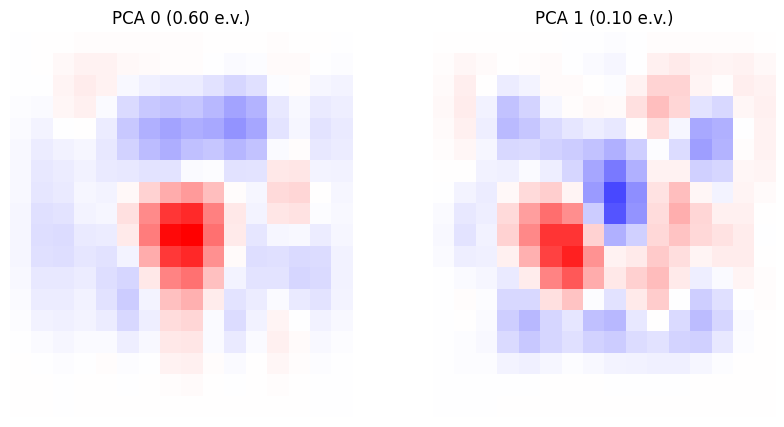

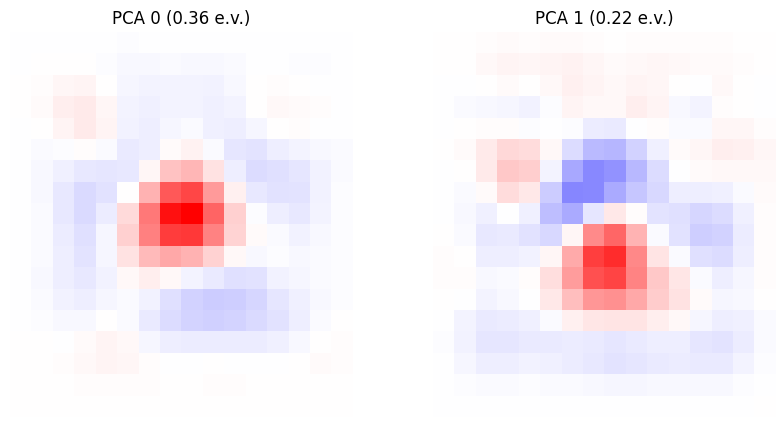

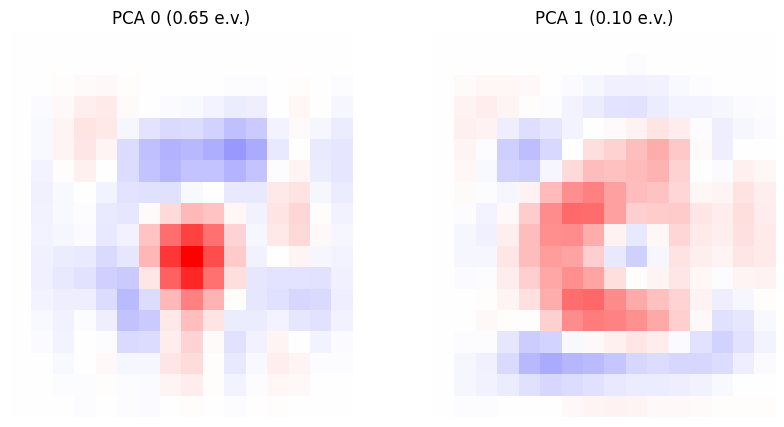

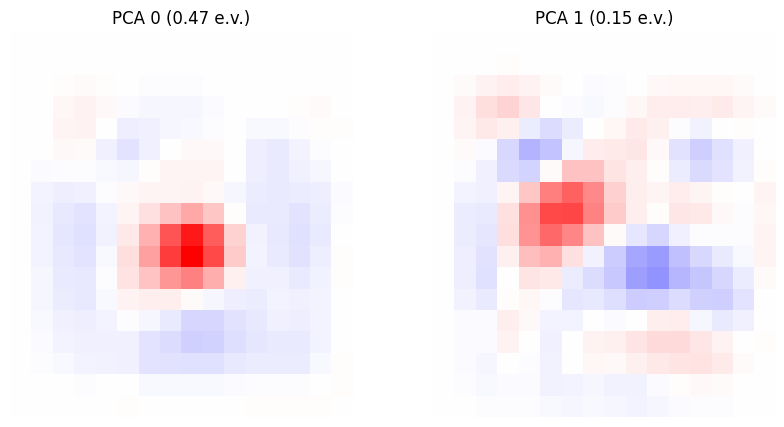

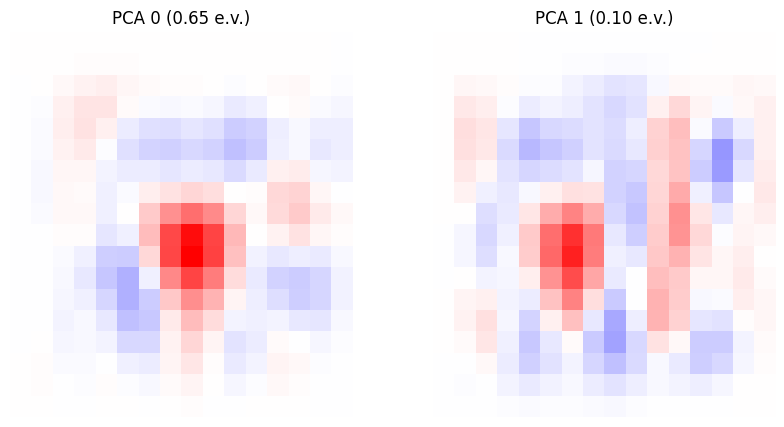

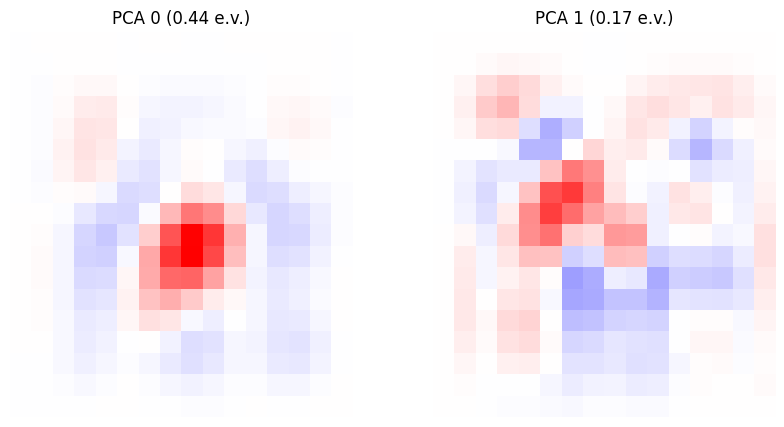

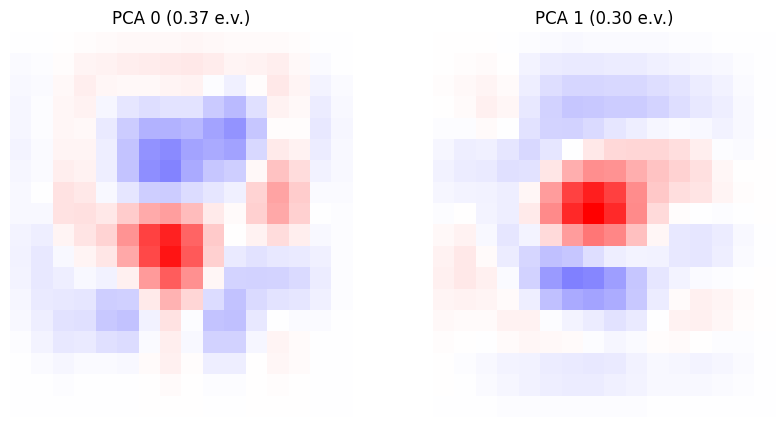

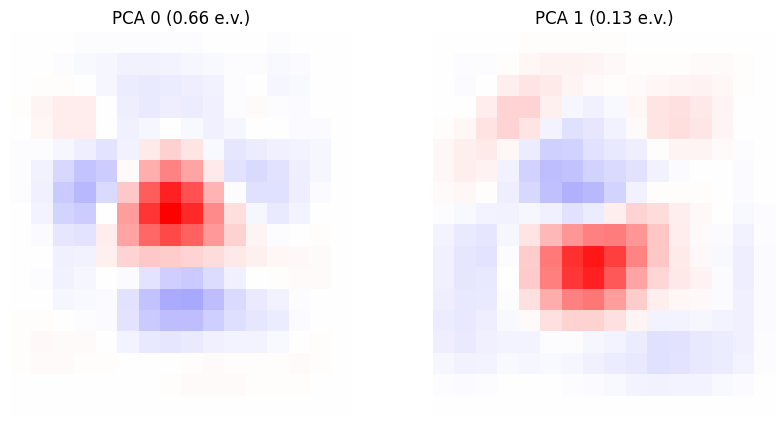

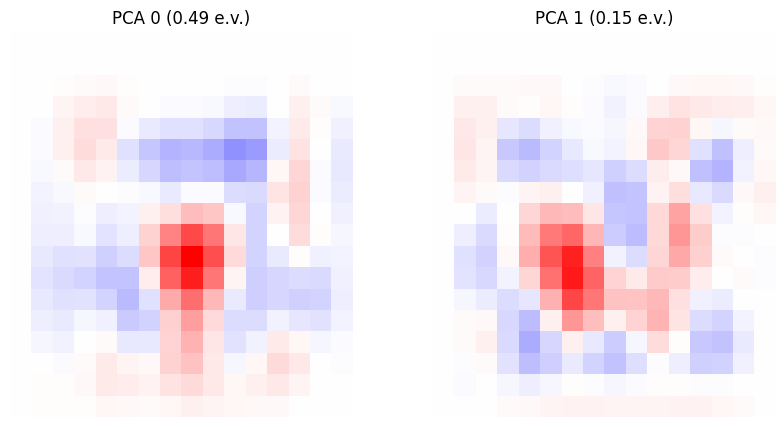

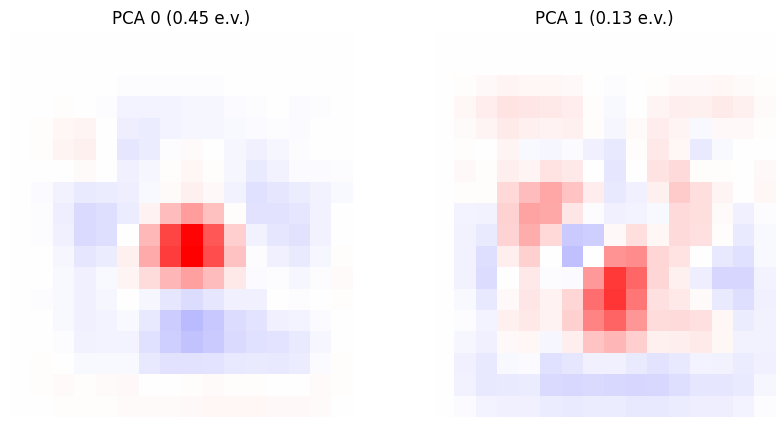

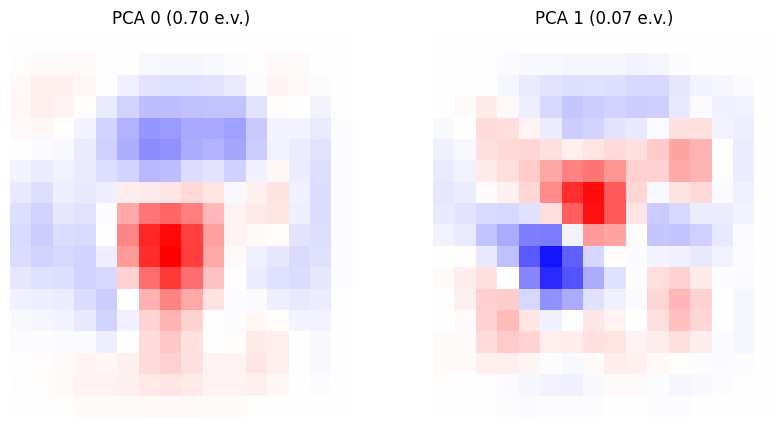

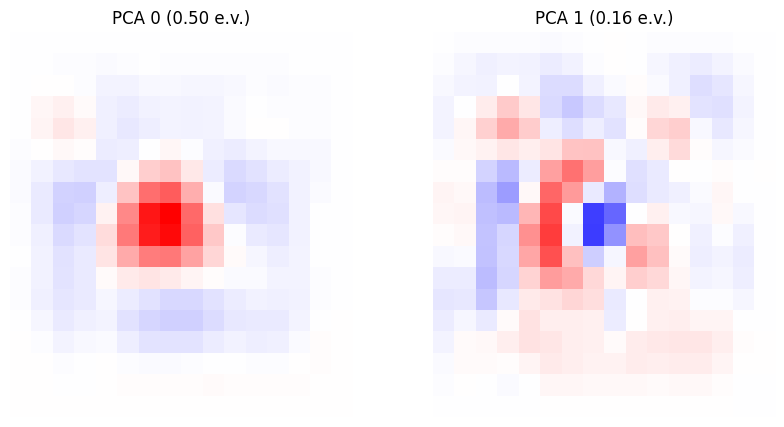

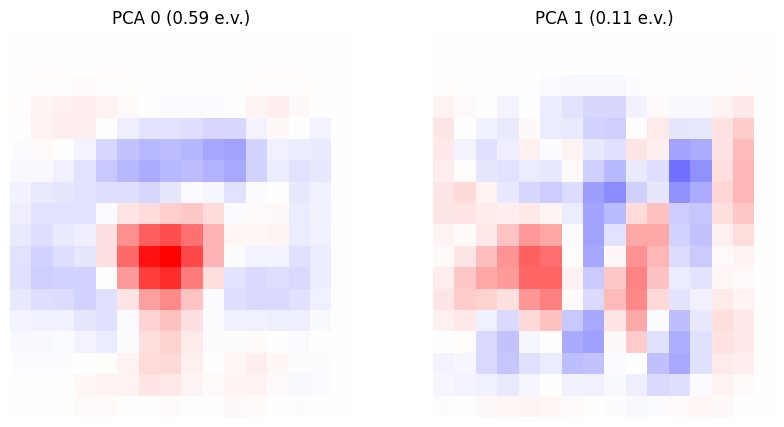

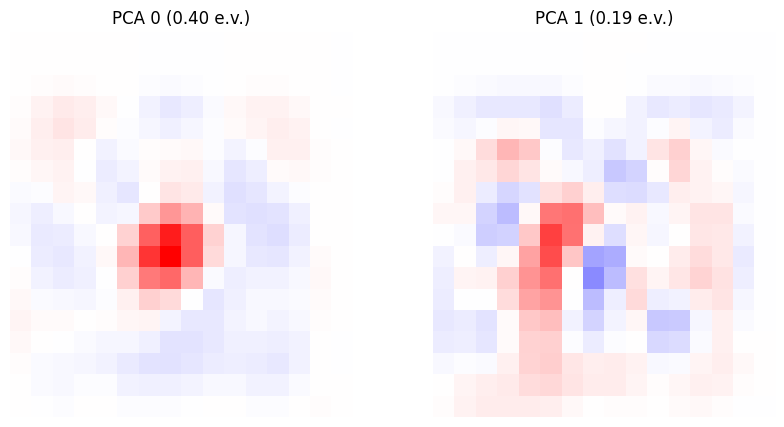

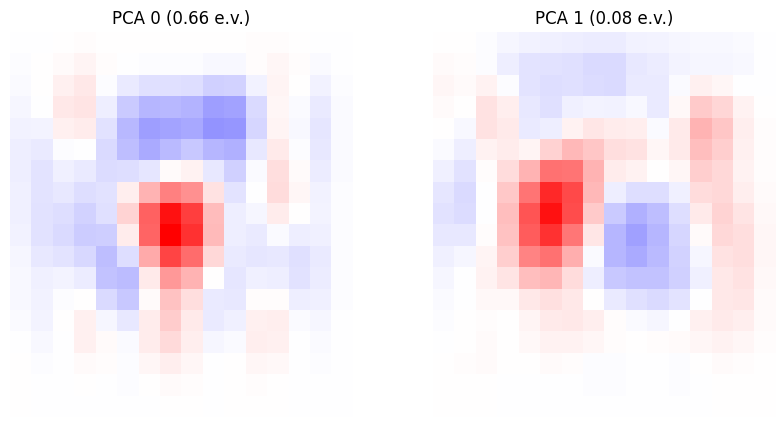

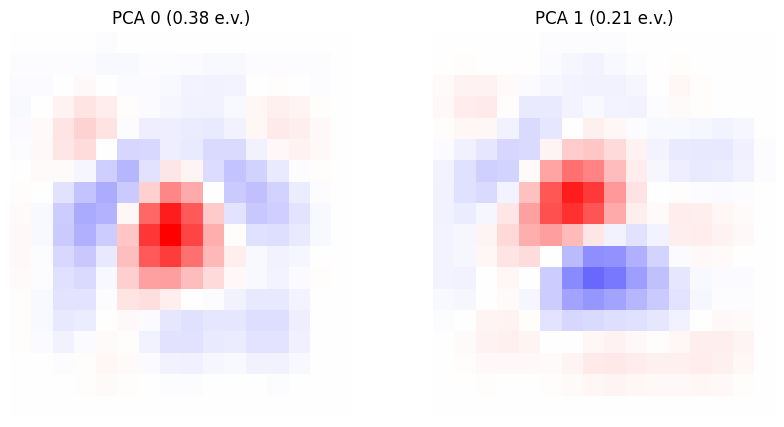

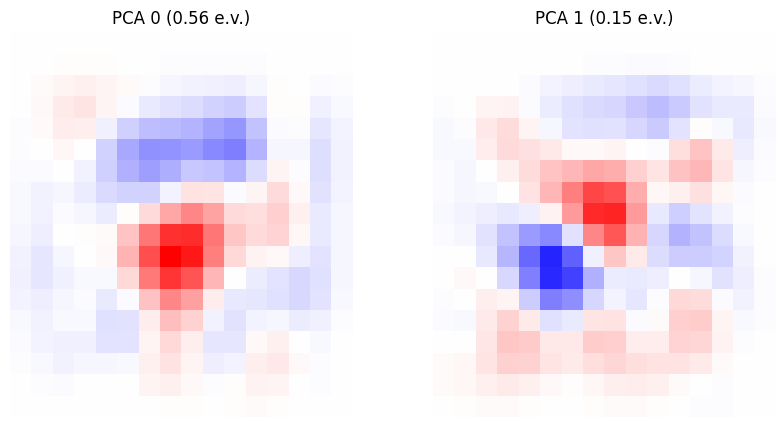

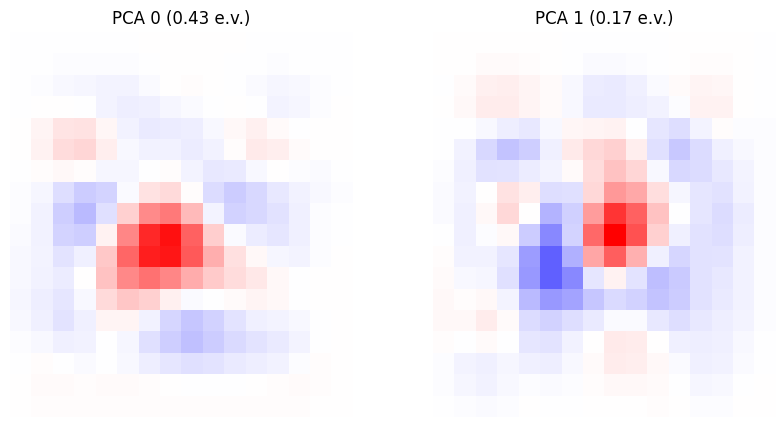

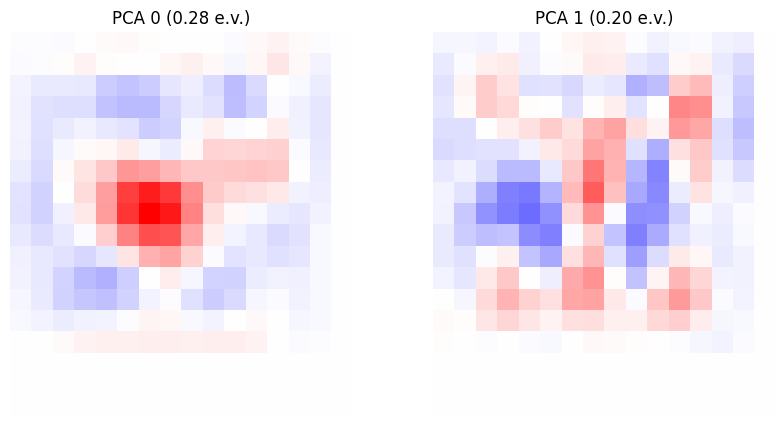

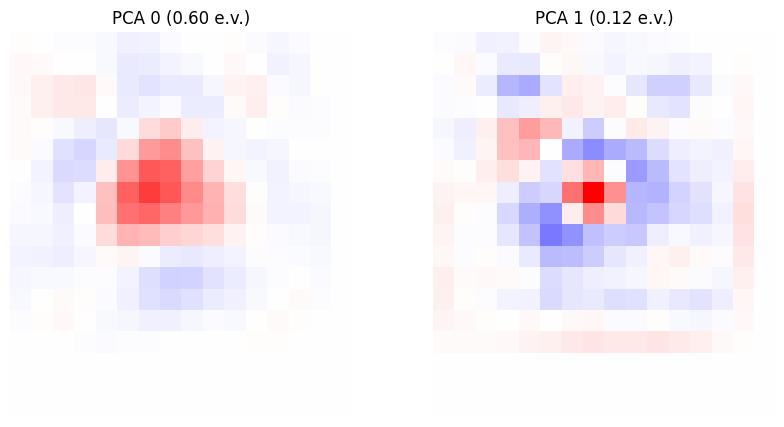

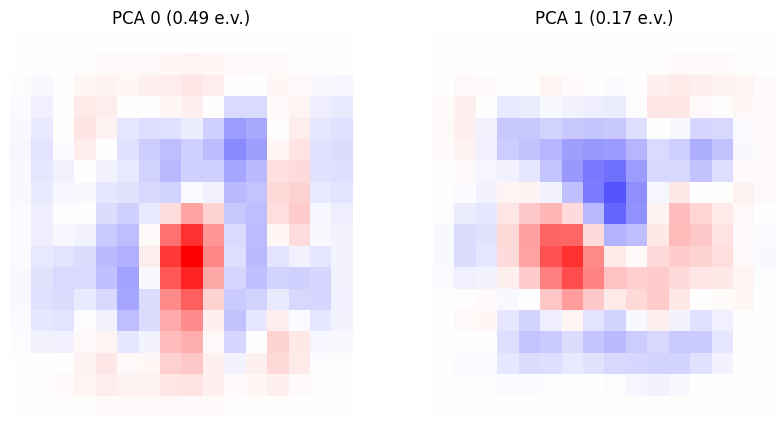

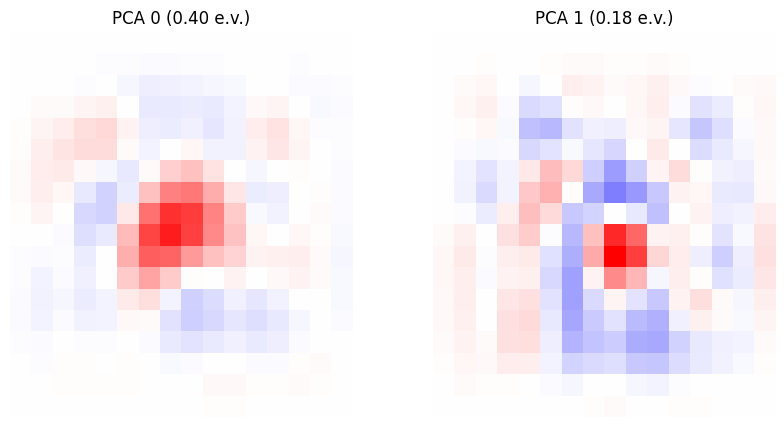

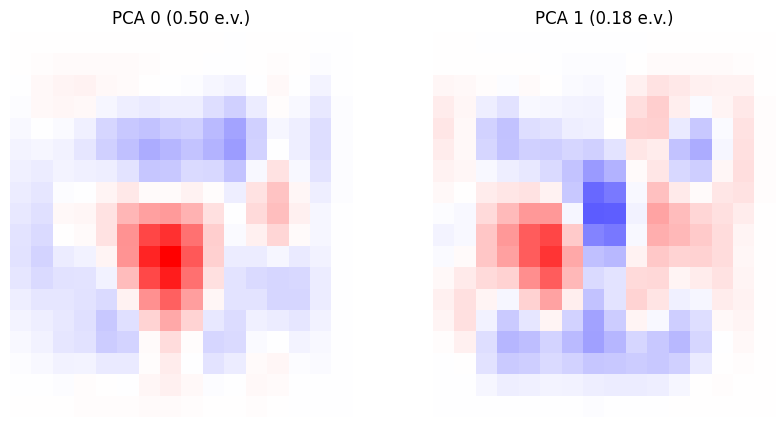

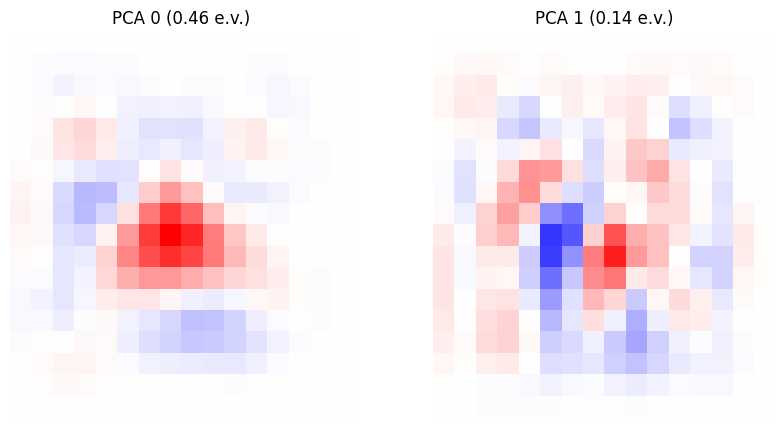

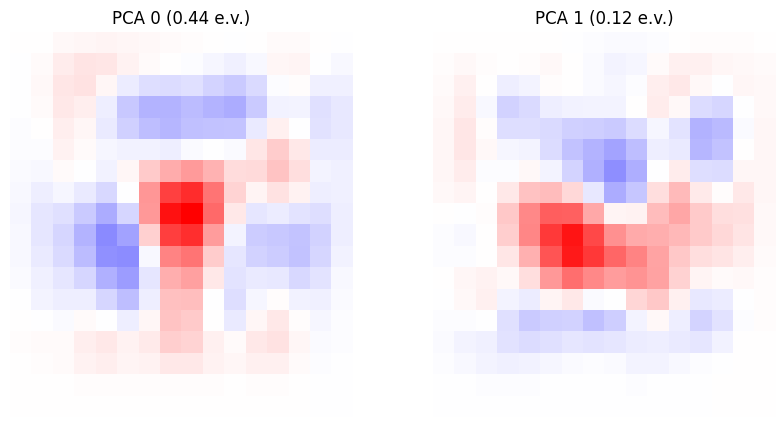

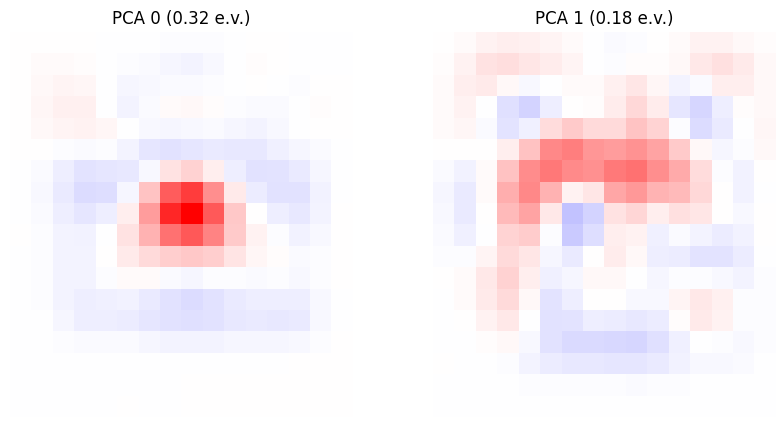

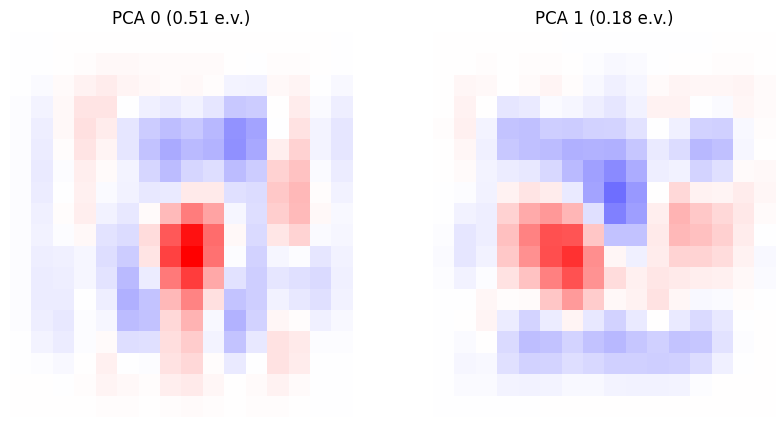

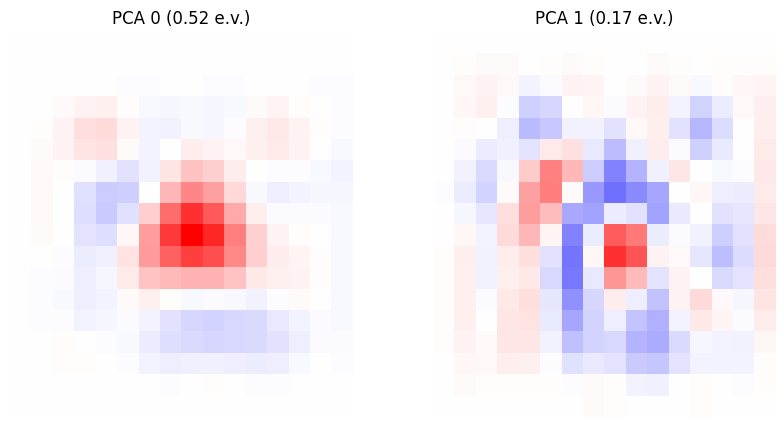

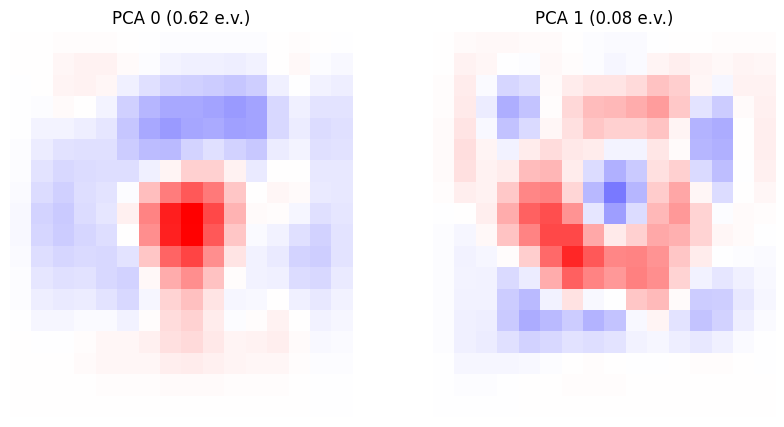

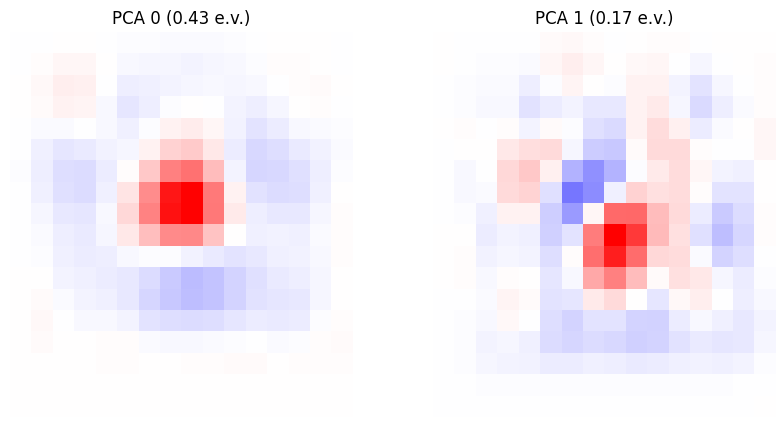

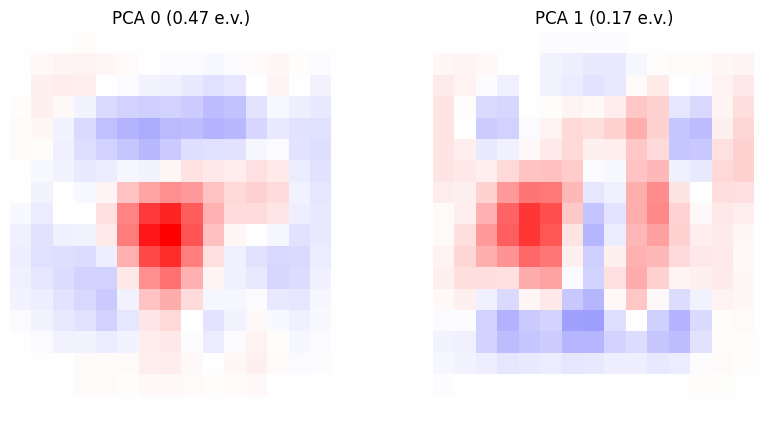

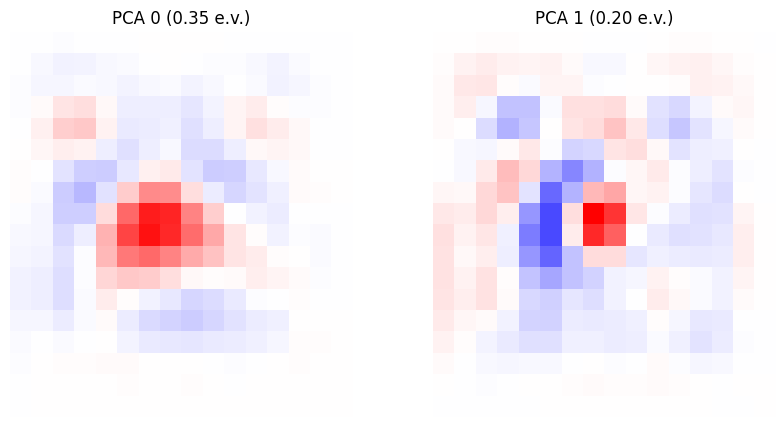

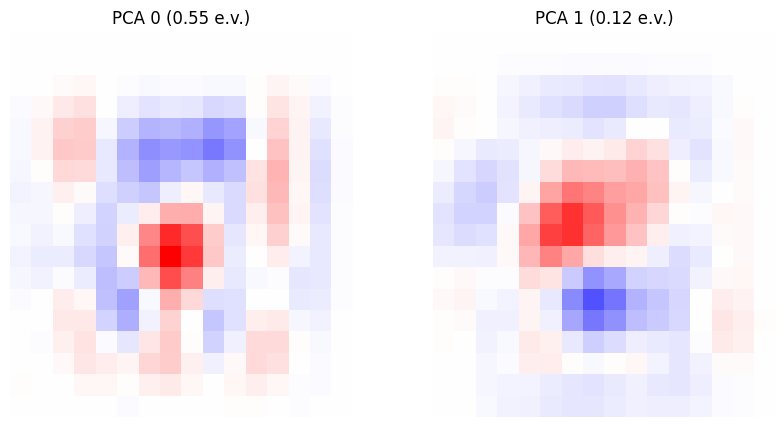

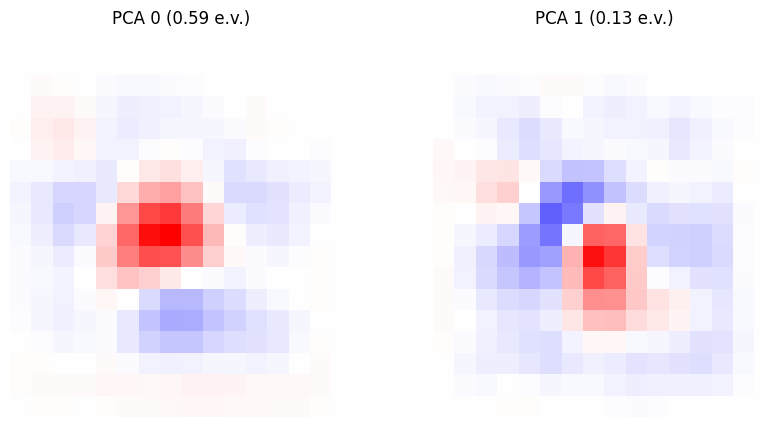

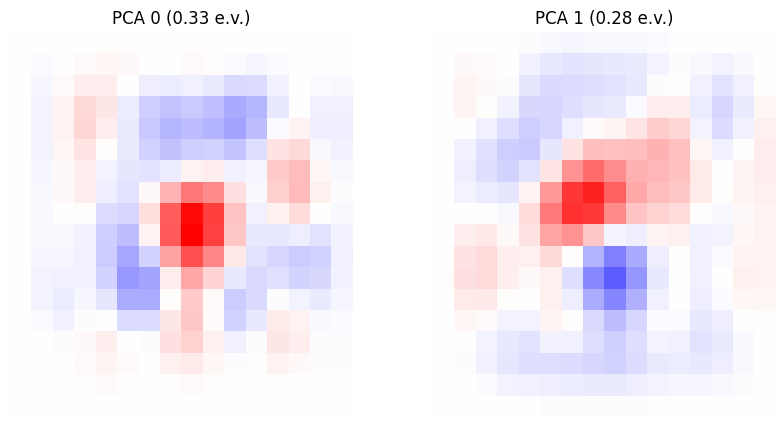

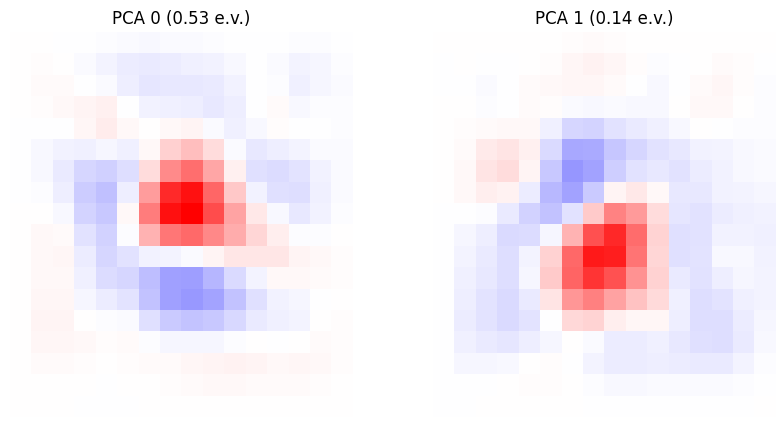

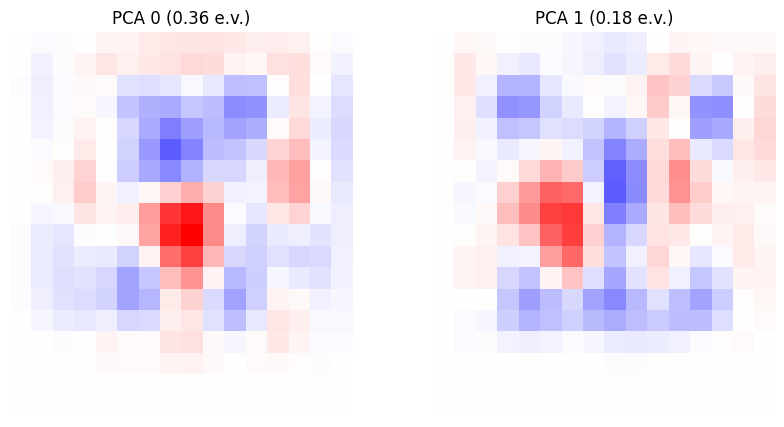

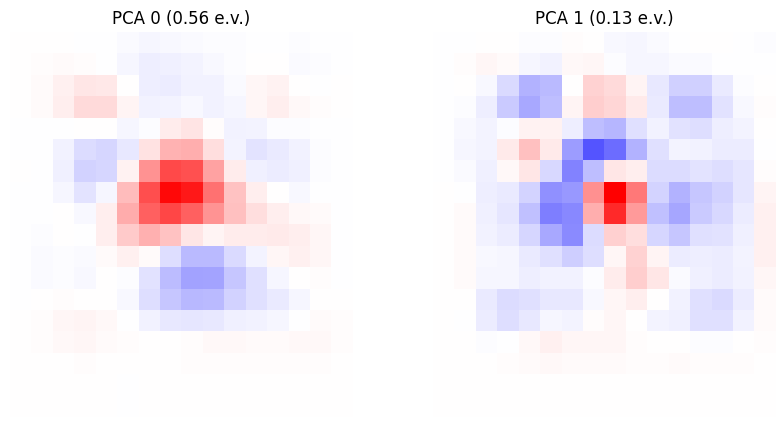

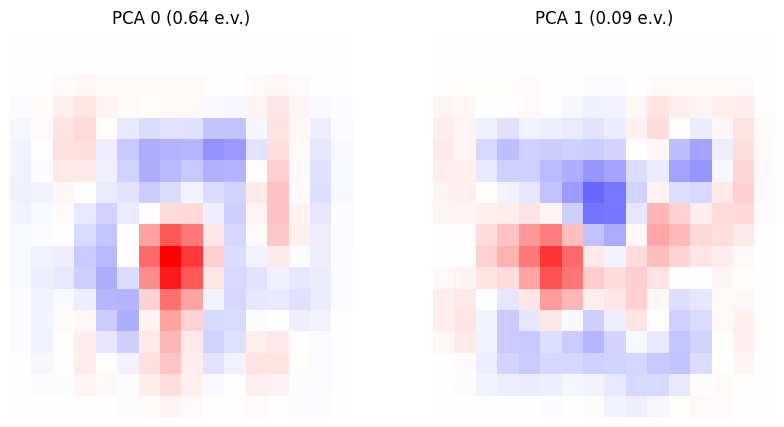

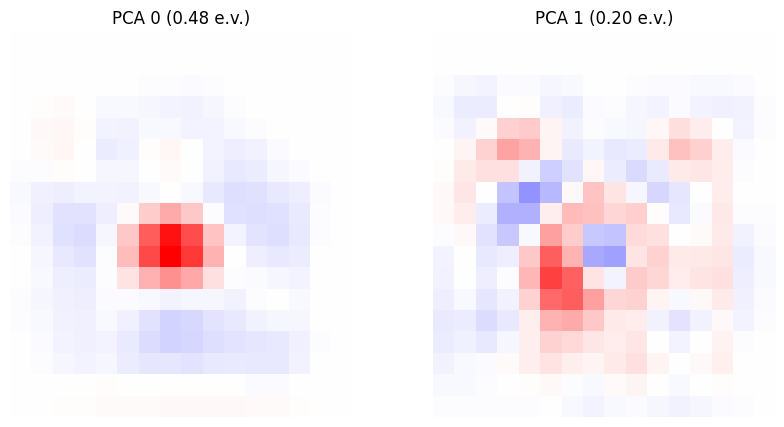

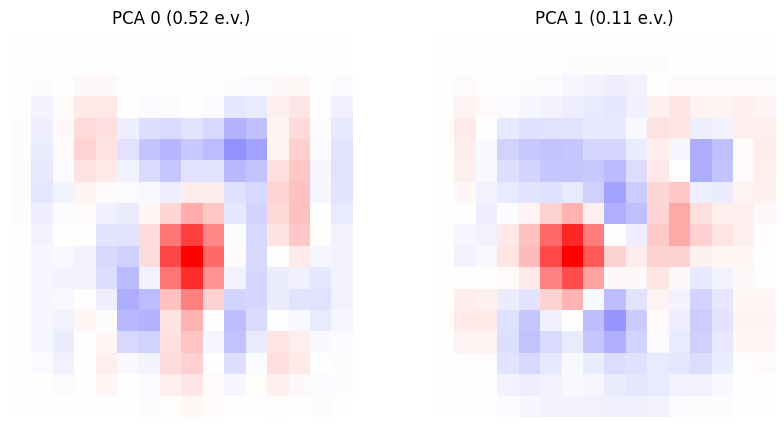

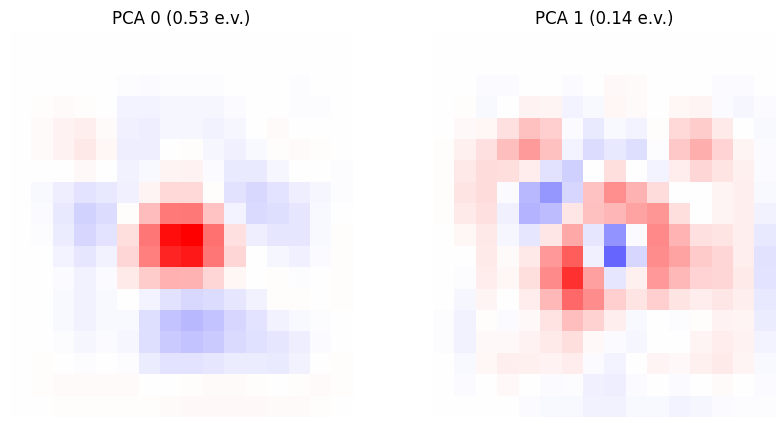

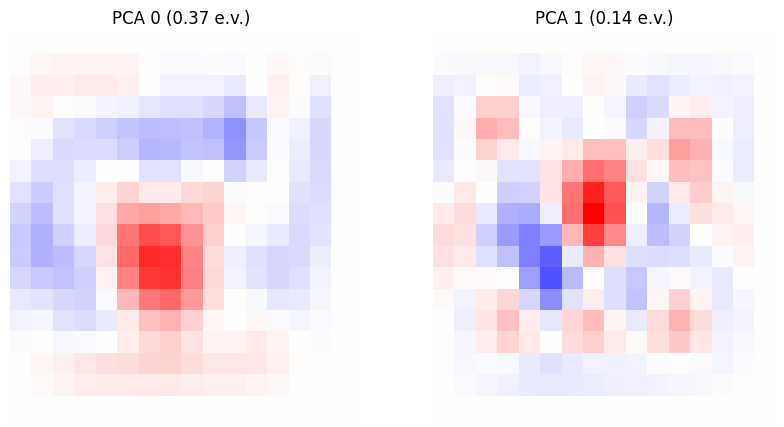

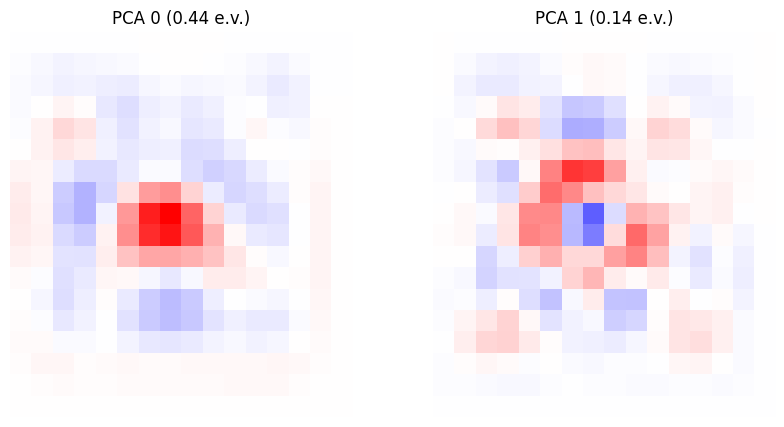

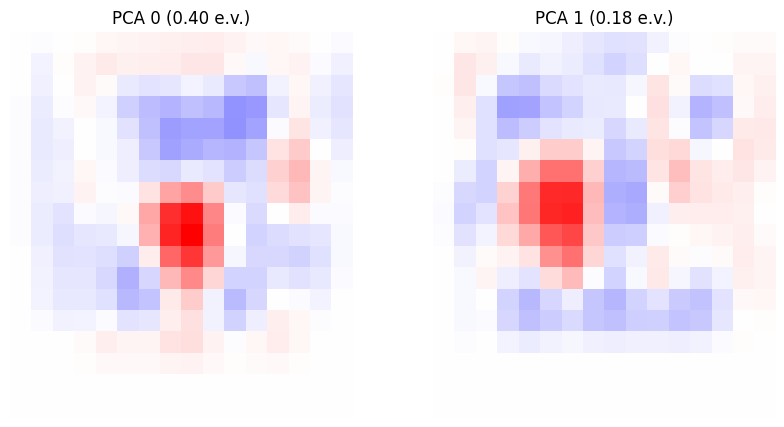

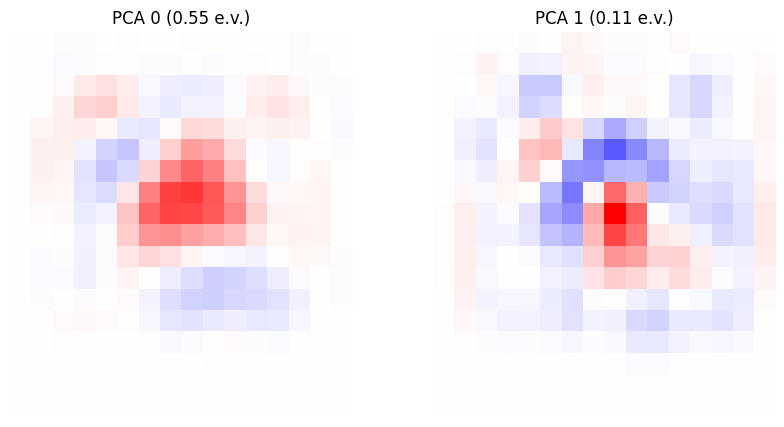

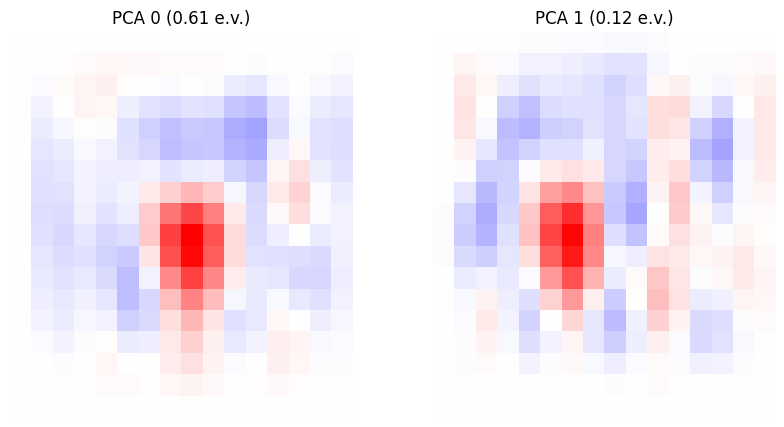

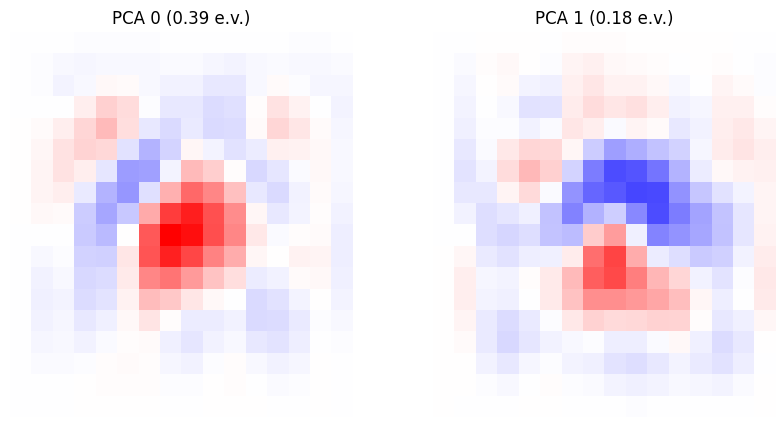

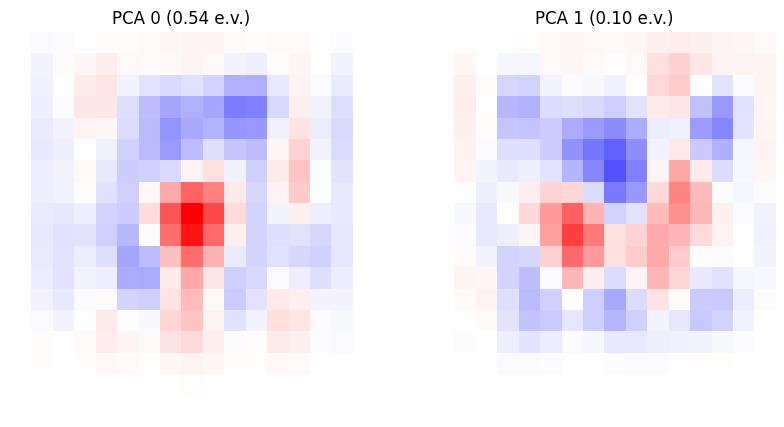

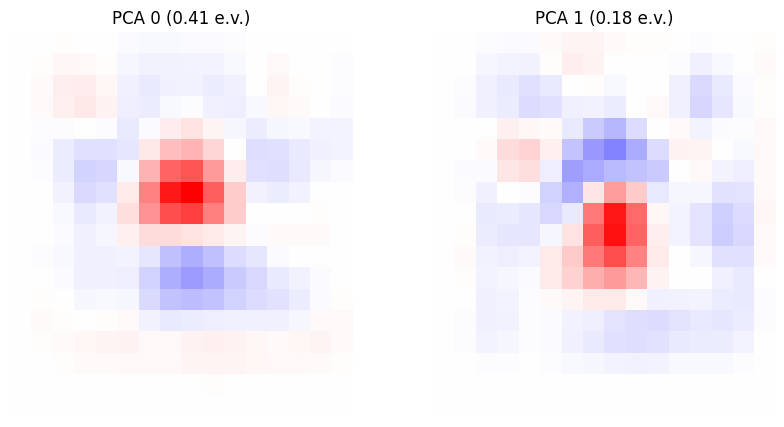

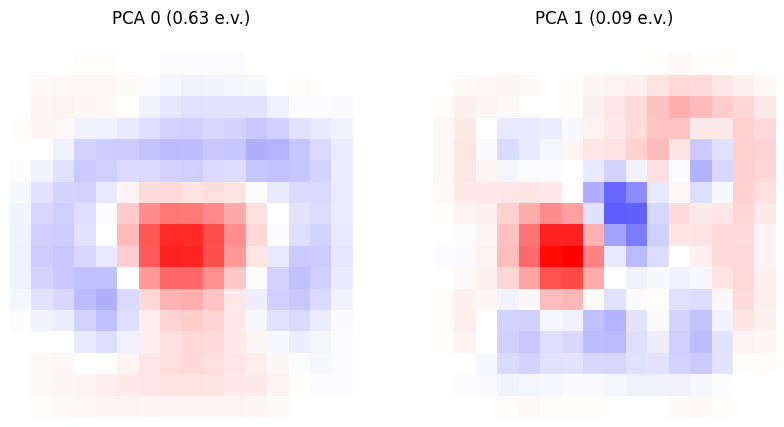

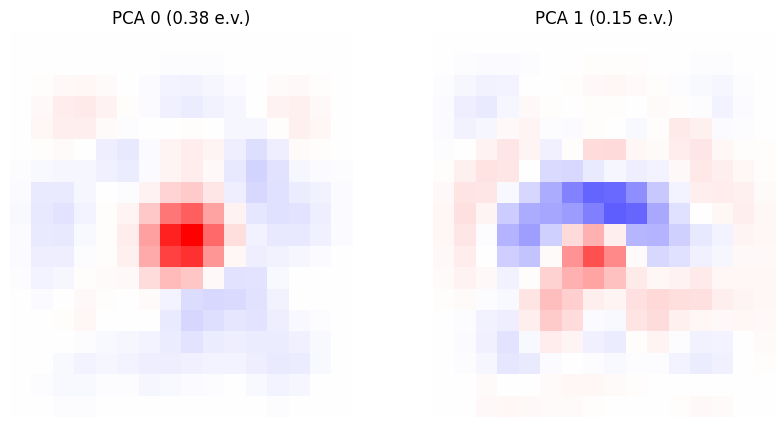

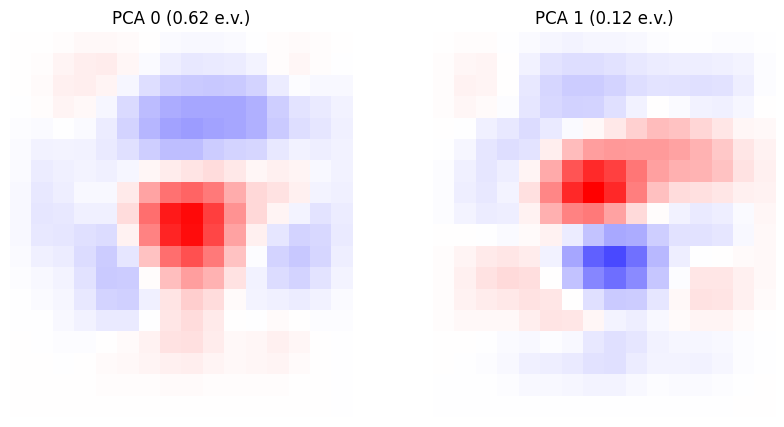

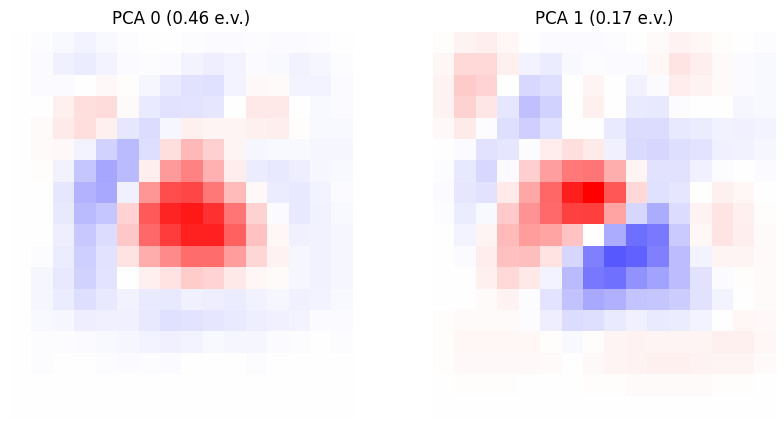

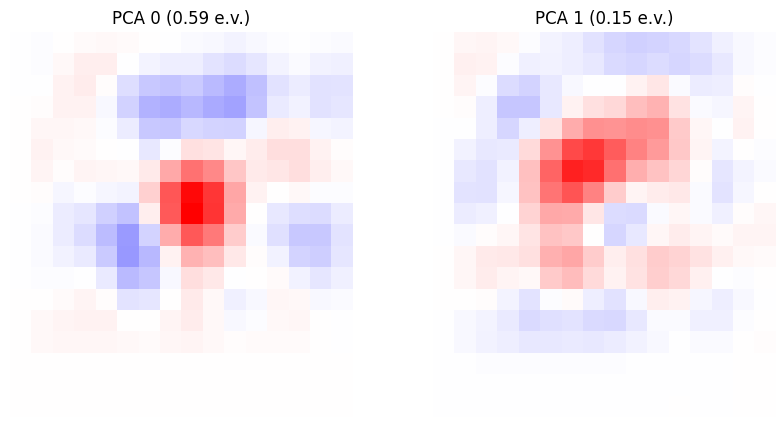

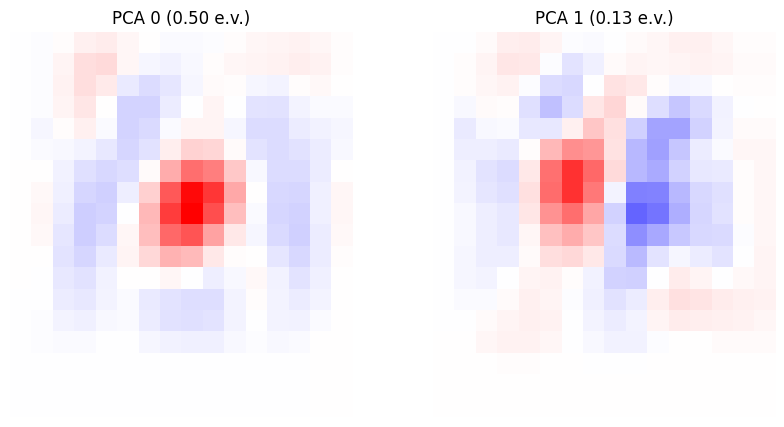

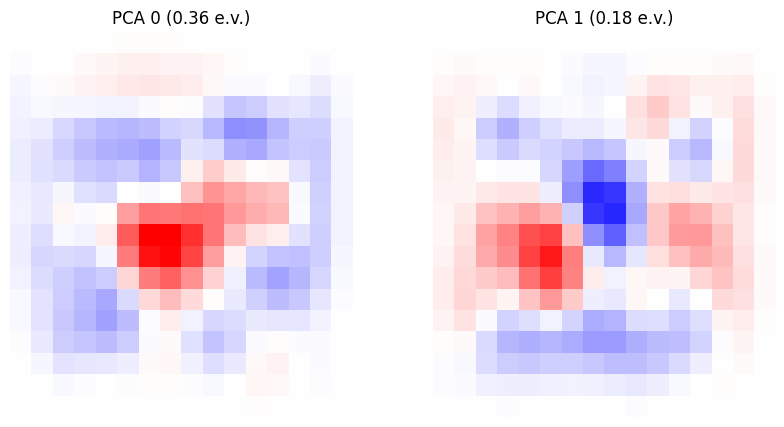

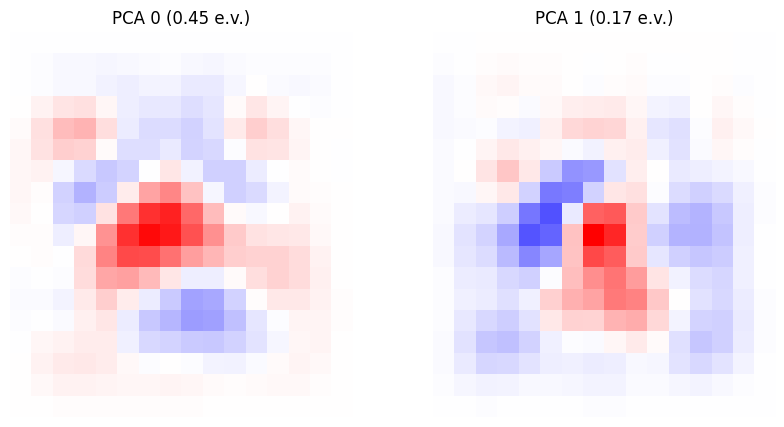

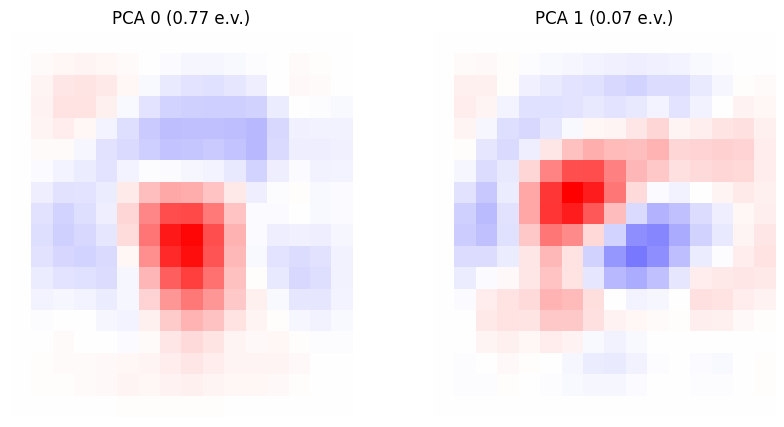

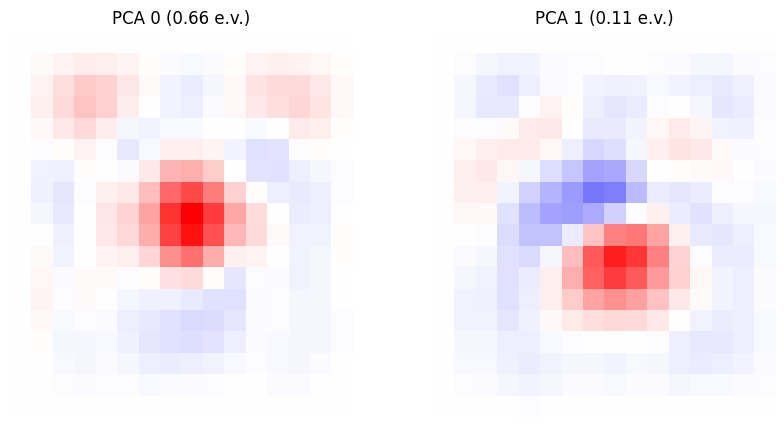

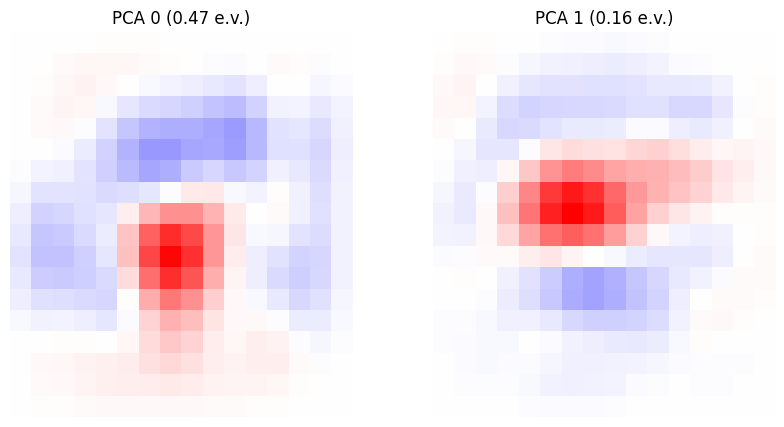

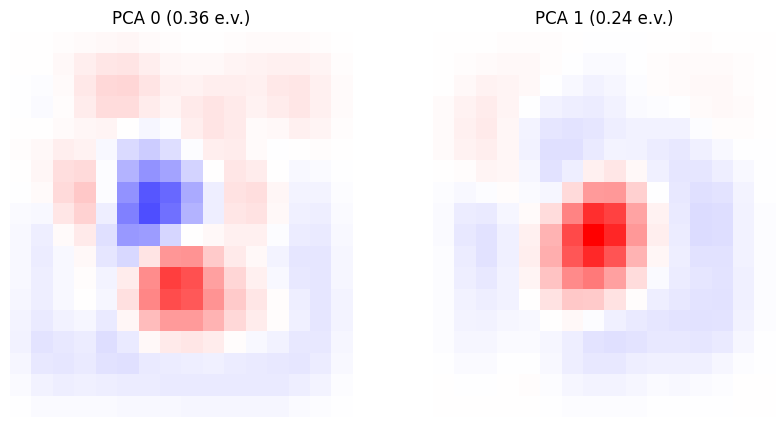

In [ ]:
path_to_save = "hoefling_low_res_vector_fields_double_variance_gru"
for session_id in list(model.readout.keys()):
    os.makedirs(f"{path_to_save}/{session_id}", exist_ok=True)
    n_neurons = model.readout[session_id].outdims 
    print(n_neurons)
    movies, n_empty_frames = prepare_movies_dataset(
        model,
        session_id,
        normalize_movies=False,  # Already normalized
        image_library=natural_images_library,
        n_image_frames=60,
        device=device,
    )
    # Double the variance for each channel in movies
    for c in range(2):
        channel_mean = movies[:, c].mean()
        movies[:, c] = (movies[:, c] - channel_mean) * 3 + channel_mean
    for cell_id in range(n_neurons):        
        assignment = model.data_info["sessions_kwargs"][session_id]["group_assignment"][cell_id]
        if assignment != 10:
            continue
        lsta_library, response_library = compute_lsta_library(
            model, movies, session_id, cell_id, integration_window=(5,35), batch_size=64, device=device
        )

        print(f"Processing cell {cell_id}...")
        for channel in range(2):
            PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)
            images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)
            fig = plot_clean_vectorfield(
                lsta_library,
                channel,
                PC1,
                PC2,
                images,
                images_coordinate,
                explained_variance,
                responses=response_library,
                x_bins=16,
                y_bins=16,
                scale_factor=0.6,
            )
            fig.axes[0].legend()
            plt.savefig(
                os.path.join(path_to_save, f"{session_id}/{session_id}_cell_{cell_id}_channel_{channel}_group_{assignment}.png"),
                dpi=300,
                bbox_inches="tight",
            )
            plt.close(fig)